In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
model = models.vgg16(pretrained = True).to(device)

c:\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
summary(model, torch.zeros(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

In [4]:
training_data_path = 'data/archive/training_set/training_set/'
test_data_path = 'data/archive/test_set/test_set/'

In [9]:
class CatsDogs(Dataset):
    def __init__(self,folder):
        print(folder + 'cats/*.jpg')
        self.cats = glob(folder + 'cats/*.jpg')
        self.dogs = glob(folder + 'dogs/*.jpg')
        self.fpaths = self.cats[:500] + self.dogs[:500]
        self.normalize = transforms.Normalize(mean=[0.485,0.456,.0442],std=[0.223,0.202,0.221])
        from random import shuffle, seed; seed(10);
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath \
        in self.fpaths]
    def __len__(self):
        return len(self.targets)
    def __getitem__(self,ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im,(224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return (
            im.float().to(device),
            torch.tensor([target]).float().to(device)
        )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data/archive/training_set/training_set/cats/*.jpg


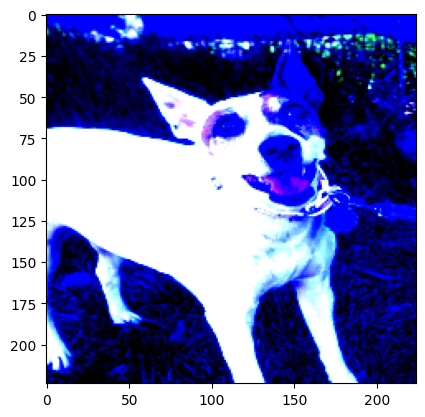

In [10]:
data = CatsDogs(training_data_path)
im,target = data[230]
plt.imshow(im.permute(1,2,0).cpu())

In [11]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parmeters(),lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [16]:
for idx, n in enumerate(model.modules()):
    print (idx , '--->' , n)

0 ---> VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil